In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
import re

In [2]:
car_df = pd.read_csv('ca683_assignment_used_cars\Dataset\autos.csv').drop("index", axis=1)
df = car_df.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [4]:
c = 1
# df['price'] = np.log(df['price'] + c)
df['price_winsorized'] = winsorize(df['price'], limits=[0.1, 0.1])
df['price_winsorized'] = np.log(df['price_winsorized'] + c)

In [5]:
most_common = df["notRepairedDamage"].value_counts(ascending=False).index[0] # Find the most common value in the 'notRepairedDamage' column and assign it to the variable 'most_common'
df["notRepairedDamage"].fillna(most_common, inplace=True) # Replace missing values in notRepairedDamage column with most common value
most_common = df["vehicleType"].value_counts(ascending=False).index[0] # Find the most common value in the 'vehicleType' column and assign it to the variable 'most_common'
df["vehicleType"].fillna(most_common, inplace=True) # Replace missing values in vehicleType column with most common value
most_common = df["fuelType"].value_counts(ascending=False).index[0] # Find the most common value in the 'fuelType' column and assign it to the variable 'most_common'
df["fuelType"].fillna(most_common, inplace=True) # Replace missing values in vehicleType column with most common value
most_common = df["gearbox"].value_counts(ascending=False).index[0] # Find the most common value in the 'gearbox' column and assign it to the variable 'most_common'
df["gearbox"].fillna(most_common, inplace=True) # Replace missing values in gearbox column with most common value
# df["model"].fillna("unknown", inplace=True)
df['model'].fillna('unknown', inplace=True)

# dropping unnecessary columns
useless_col = ["nrOfPictures", "lastSeen", "dateCrawled", "name", "monthOfRegistration", "dateCreated", "postalCode", "seller", "offerType"] # Identify columns that are not useful for analysis and store them in a list called 'useless_col
data = df.drop(useless_col, axis=1) # Drop the unnecessary columns from the 'used_car_data' dataframe and store the resulting dataframe in 'new_used_car'
data['notRepairedDamage'] = pd.factorize(data['notRepairedDamage'])[0]
data['abtest'] = pd.factorize(data['abtest'])[0]
data['gearbox'] = pd.factorize(data['gearbox'])[0]

In [6]:
def outlier(value):
    Q1 = np.percentile(data[value], 25)
    Q3 = np.percentile(data[value], 75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    data[data[value] > upper] = np.nan
    data[data[value] < lower] = np.nan

In [7]:
for i in ['yearOfRegistration', 'powerPS']:
    outlier(i)

In [8]:
data.dropna(inplace=True)

In [9]:
# assigning dummy variables to categorical variables
data_dummy = pd.get_dummies(data, prefix='vehicleType', prefix_sep='.', 
                            columns=['vehicleType'])
data_dummy = pd.get_dummies(data_dummy, prefix='fuelType', prefix_sep='.', 
                            columns=['fuelType'], drop_first=True)
data_dummy = pd.get_dummies(data_dummy, prefix='brand', prefix_sep='.', 
                            columns=['brand'], drop_first=True)
data_dummy = pd.get_dummies(data_dummy, prefix='model', prefix_sep='.', 
                            columns=['model'], drop_first=True)

data_dummy['yearOfRegistration'] = data_dummy['yearOfRegistration'].astype(int)

data_dummy['year_range'] = pd.cut(data_dummy['yearOfRegistration'], bins=range(data_dummy['yearOfRegistration'].min(), data_dummy['yearOfRegistration'].max()+6, 5), right=False)
data_dummy = pd.get_dummies(data_dummy, prefix='year_range', prefix_sep='.', columns=['year_range'], drop_first=True)
scaler = StandardScaler()
data_dummy['powerPS'] = scaler.fit_transform(data_dummy[['powerPS']])
data_dummy['kilometer'] = scaler.fit_transform(data_dummy[['kilometer']])

In [10]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data_dummy.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_dummy.columns.values]

In [11]:
data_dummy.drop(['price'],axis=1, inplace=True)
y = data_dummy['price_winsorized']
X = data_dummy.drop(['price_winsorized'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1, 
    random_state=42)

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
xgb_model = xgb.XGBRegressor(tree_method="hist", max_depth=14, learning_rate=0.1, n_estimators=220
                            )
xgb_model.fit(X_train, y_train, eval_metric="mae", early_stopping_rounds=5 ,eval_set=[(X_test,y_test)], verbose=1)
y_pred = xgb_model.predict(X_test)


[0]	validation_0-mae:6.69972


C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:6.03037
[2]	validation_0-mae:5.42815
[3]	validation_0-mae:4.88616
[4]	validation_0-mae:4.39831
[5]	validation_0-mae:3.95922
[6]	validation_0-mae:3.56414
[7]	validation_0-mae:3.20853
[8]	validation_0-mae:2.88869
[9]	validation_0-mae:2.60067
[10]	validation_0-mae:2.34252
[11]	validation_0-mae:2.11079
[12]	validation_0-mae:1.90293
[13]	validation_0-mae:1.71638
[14]	validation_0-mae:1.54930
[15]	validation_0-mae:1.39965
[16]	validation_0-mae:1.26565
[17]	validation_0-mae:1.14580
[18]	validation_0-mae:1.03912
[19]	validation_0-mae:0.94447
[20]	validation_0-mae:0.86064
[21]	validation_0-mae:0.78661
[22]	validation_0-mae:0.72149
[23]	validation_0-mae:0.66446
[24]	validation_0-mae:0.61478
[25]	validation_0-mae:0.57162
[26]	validation_0-mae:0.53417
[27]	validation_0-mae:0.50176
[28]	validation_0-mae:0.47381
[29]	validation_0-mae:0.44956
[30]	validation_0-mae:0.42867
[31]	validation_0-mae:0.41077
[32]	validation_0-mae:0.39550
[33]	validation_0-mae:0.38230
[34]	validation_0-m

In [13]:
y_pred1 = np.exp(y_pred)
y_test1= np.exp(y_test)
y_test1

135920      601.0
46519      6901.0
170242     1601.0
270686    14001.0
299602    11781.0
           ...   
19649      4991.0
227388     6301.0
113962     7991.0
47181      1701.0
12631       501.0
Name: price_winsorized, Length: 36439, dtype: float64

In [14]:
y_pred1 = np.exp(y_pred)
y_test1= np.exp(y_test)
print('mean_absolute_error = ', mean_absolute_error(y_test1,y_pred1))
print('R2 score is ',r2_score(y_test1, y_pred1))
print('mean_squared_error is ', mean_squared_error(y_test1, y_pred1))
print('mean_absolute_error = ', mean_absolute_error(y_test,y_pred))
print('R2 score is ',r2_score(y_test, y_pred))
print('mean_squared_error is ', mean_squared_error(y_test, y_pred))

mean_absolute_error =  909.8140738252296
R2 score is  0.8761059528984096
mean_squared_error is  2459757.36484259
mean_absolute_error =  0.29238909275741093
R2 score is  0.8320102663389172
mean_squared_error is  0.19866534398913388


In [15]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_jobs=-1, verbose=1)
rf_model.fit(X_train, y_train)
y_pred2 = rf_model.predict(X_test)
y_pred3 = np.exp(y_pred)
y_test1= np.exp(y_test)
print('mean_absolute_error = ', mean_absolute_error(y_test1,y_pred3))
print('R2 score is ',r2_score(y_test1, y_pred3))
print('mean_squared_error is ', mean_squared_error(y_test1, y_pred3))
print('mean_absolute_error = ', mean_absolute_error(y_test,y_pred2))
print('R2 score is ',r2_score(y_test, y_pred2))
print('mean_squared_error is ', mean_squared_error(y_test, y_pred2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


mean_absolute_error =  909.8140738252296
R2 score is  0.8761059528984096
mean_squared_error is  2459757.36484259
mean_absolute_error =  0.2980151278528547
R2 score is  0.8163699020321311
mean_squared_error is  0.2171617025903788


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


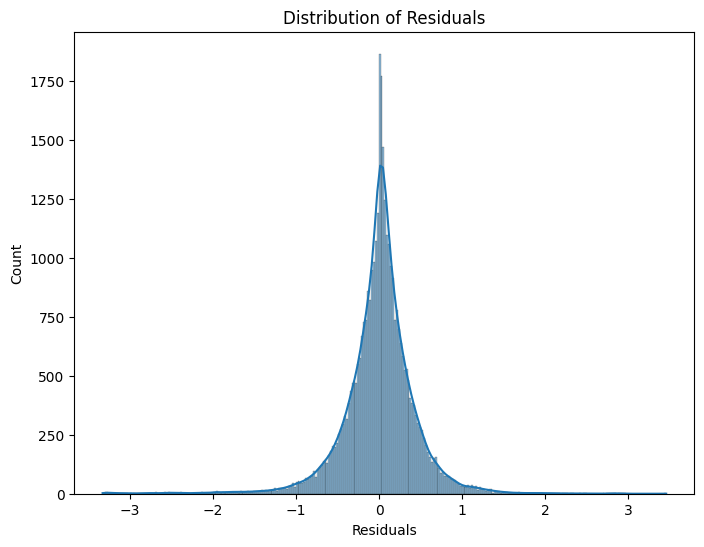

In [75]:
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results['residuals'] = results['actual'] - results['predicted']
results['residuals'] = results['actual'] - results['predicted']
plt.figure(figsize=(8, 6))
sns.histplot(x=results['residuals'], kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

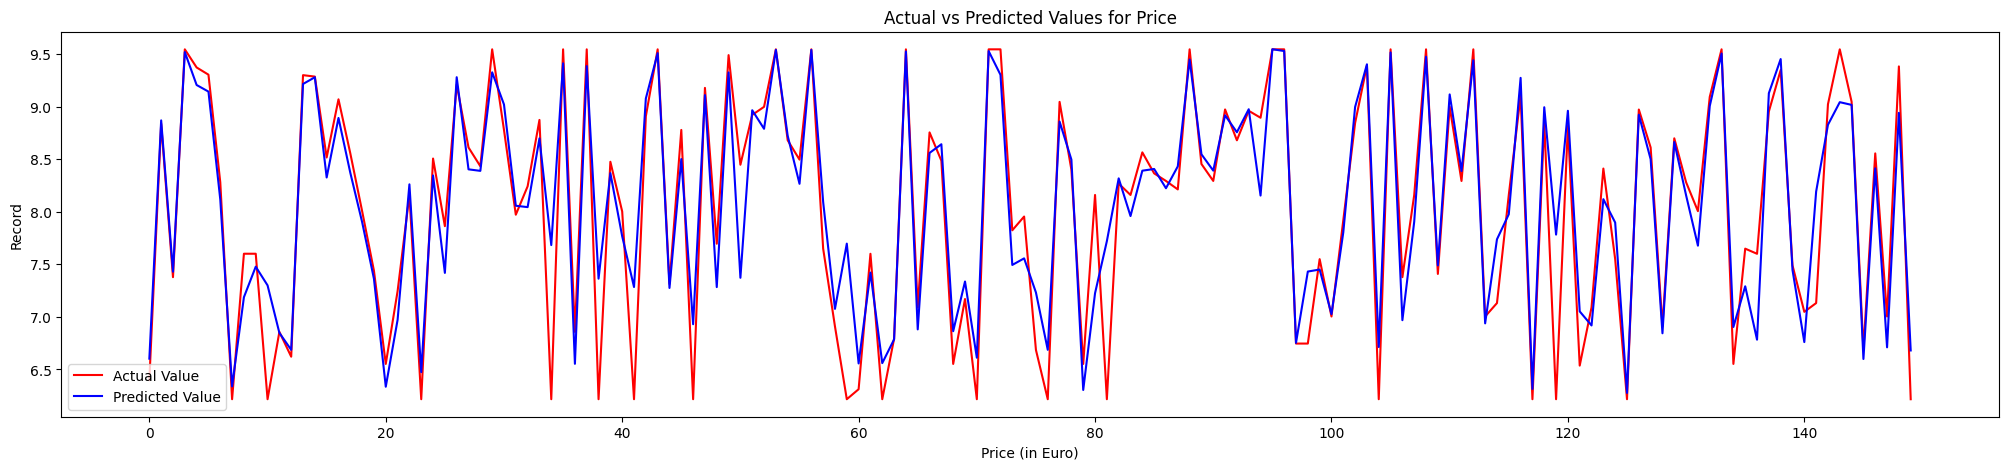

In [76]:
s = results.head(150)
s = s.reset_index()

plt.figure(figsize=(25, 5))  # increase the width of the figure
sns.lineplot(data=s['actual'], y=s['actual'], x=s.index, color='r', label="Actual Value")
sns.lineplot(data=s['predicted'], y=s['predicted'], x=s.index, color='b', label="Predicted Value")

plt.title('Actual vs Predicted Values for Price')
plt.xlabel('Price (in Euro)')
plt.ylabel('Record')

plt.show()
plt.close()